In [14]:
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys import ecephys_session
%matplotlib inline

import sys
sys.path.append('../../swdb_2019_tools')
# import Neuropixels_timeseries
import spikeutils

# fix slow autocomplete
%config Completer.use_jedi = False

In [15]:
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # OS X 
    data_root = "/Volumes/Brain2019/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2019/"

manifest_path = os.path.join(data_root, "dynamic-brain-workshop/visual_coding_neuropixels/2019/manifest.json")

<b>Acquire Data</b>

In [16]:
cache = EcephysProjectCache.fixed(manifest=manifest_path)
sessions = cache.get_sessions()

#find all sessions with region of interest
hcareas = ['CA']
hc_sessions = []
for i in np.arange(len(sessions.structure_acronyms)):
    sessionid = sessions.structure_acronyms.index[i]
    if any(elem in sessions.structure_acronyms[sessionid] for elem in hcareas):
        hc_sessions.append(sessionid)

#choose a session
seshid = hc_sessions[2]

#get all units and channels
allunits = cache.get_units(annotate=True)
channelinfo = cache.get_channels()

#choose units that are on appropriate channels
ca_channelinfo = channelinfo[channelinfo.manual_structure_acronym == hcareas[0]]
ca_units = allunits[(allunits.peak_channel_id.isin(ca_channelinfo.index))&(allunits.ecephys_session_id == seshid)]

#get session data for chosen session
session = cache.get_session_data(seshid)

##### different way to pull units (slower in my experience) #####
# ca_units = session.units[session.units.structure_acronym=='CA']

In [6]:
seshid

744228101

In [7]:
len(ca_units)

161

In [8]:
#get spike times for session
spike_times = session.spike_times

#use following two lines to make a list of spiketimes
ca_spiketimes = []
for i in range(len(ca_units)):
    unit_id = ca_units.index[i]
    ca_spiketimes.append(spike_times[unit_id])

<b>Stimulus Presentations</b>

In [9]:
# session.get_presentations_for_stimulus('natural_movie_three').stimulus_condition_id.value_counts()

In [10]:
stim_epochs = session.get_stimulus_epochs()
stim_epochs.columns
numepochs = len(stim_epochs.start_time)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [11]:
#Find unique stimulus epochs
epochlabels, epochuniques = pd.factorize(stim_epochs.stimulus_name)

In [12]:
epochuniques

Index(['spontaneous', 'gabors', 'flashes', 'drifting_gratings',
       'natural_movie_three', 'natural_movie_one', 'static_gratings',
       'natural_scenes'],
      dtype='object')

<b>Bin spikes</b>

In [13]:
########################### Make NxT array with array of times for each N ###########################
#Generate binned spiketimes matrix
binsize = 1000
# endtime = stim_epochs.stop_time.values[-1]
starttime=0
endtime = np.ceil(np.max([np.max(spikes) for spikes in ca_spiketimes]))
epochrates = spikeutils.spiketimes_to_2D_rates(ca_spiketimes,starttime,endtime,binsize=binsize).T

#assign labels
numlabels = len(np.unique(stim_epochs.stimulus_name))
np.arange(numlabels)
labels = np.zeros((int(endtime*1000/binsize)))
for i in range(numepochs):
    epochstart = (stim_epochs.start_time[i]*1000)/binsize
    epochend = (stim_epochs.stop_time[i]*1000)/binsize
    stimname = stim_epochs.stimulus_name[i]
    labels[int(epochstart):int(epochend)] = np.where(epochuniques==stimname)[0][0]

In [14]:
np.unique(labels)

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [15]:
epochrates.shape

(9774, 161)

In [16]:
labels.shape

(9774,)

In [17]:
########################### Make NxT array with one value for each N ###########################
# #need to make NxT array where T bin size is the time between epochs (or 1 second after epoch)
# epochrates = np.zeros((numepochs,len(ca_units)))
# for i in range(numepochs):
#     epochstart = stim_epochs.start_time[i]
#     end = epochstart + 2
#     spikemat = spikeutils.spiketimes_to_2D_rates(ca_spiketimes,epochstart,end,binsize=(end-epochstart)*1000)
#     epochrates[i,:] = spikemat.T

<b>PCA</b>

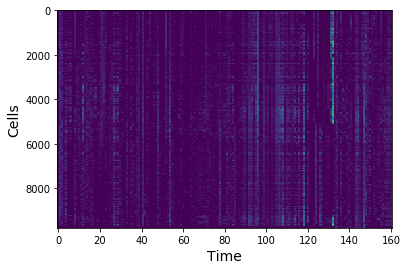

In [18]:
plt.figure()
plt.imshow(epochrates,aspect='auto');
plt.xlabel("Time", fontsize=14);
plt.ylabel("Cells", fontsize=14);

# plotname_fig1 = str(hcareas[0]) + '_FR_session' + str(seshid) +'.png'
# filename_fig1 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/'+ plotname_fig1)
# plt.savefig(filename_fig1,dpi=300)

<b>Ian's PCA methods</b>

In [15]:
from hdda.pca.PCA import PCA

In [16]:
epochrates.shape

(9774, 161)

In [17]:
epochrates = pd.DataFrame(epochrates,
                          index=['time_{}'.format(i) for i in range(epochrates.shape[0])],
                          columns=['cell_{}'.format(i) for i in range(epochrates.shape[1])])

In [18]:
pca = PCA().fit(epochrates)

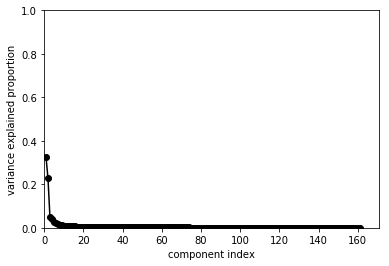

In [19]:
# pca.plot_scree()
pca.plot_var_expl_prop()

(9774, 8)


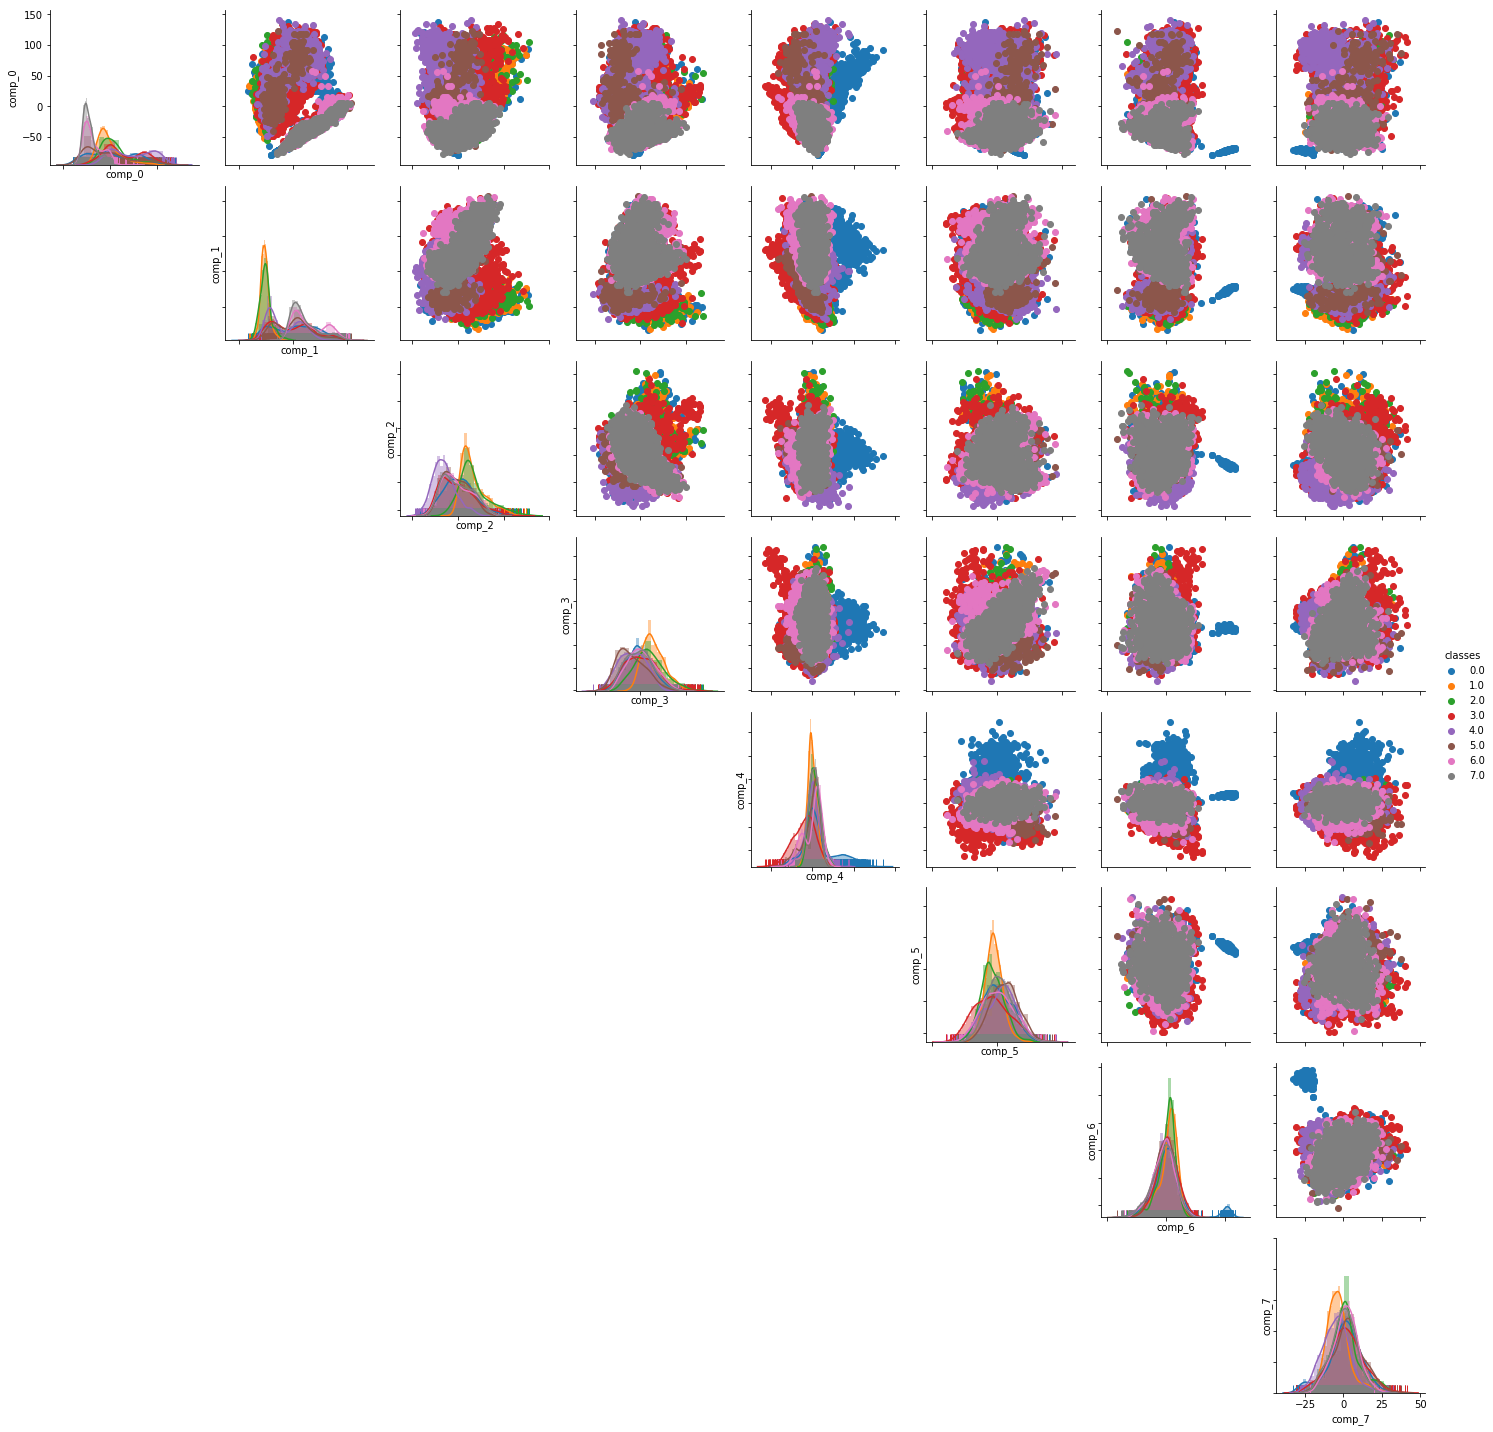

In [23]:
pca.plot_scores(n_components=8, classes=labels)

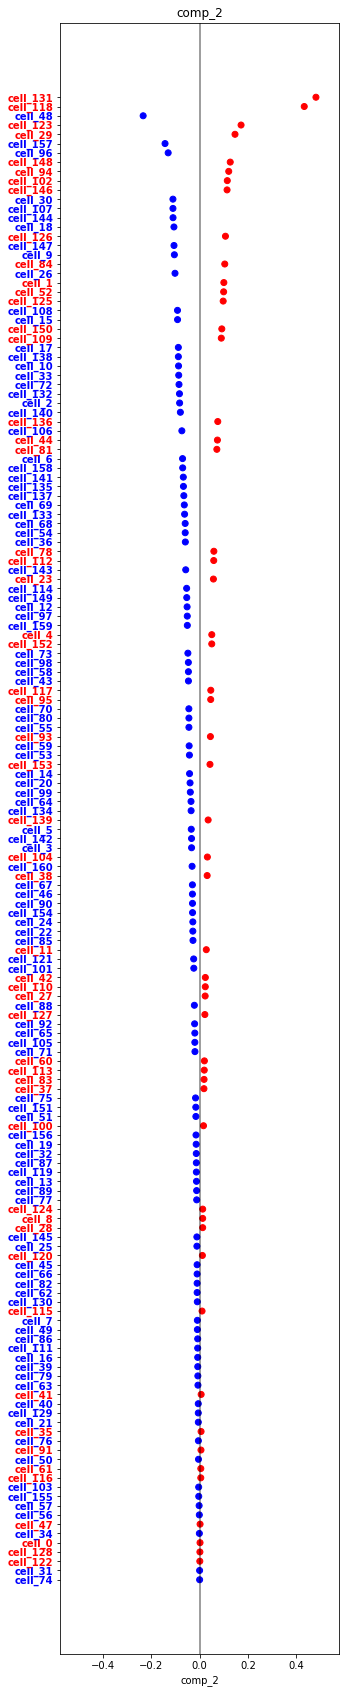

In [34]:
plt.figure(figsize=(5, 30))
pca.plot_loading(comp=2)

In [40]:
# plt.plot(pca.scores_.iloc[:, ].values)

In [21]:
pca_cell_obs = PCA().fit(epochrates.T)

(161, 5)


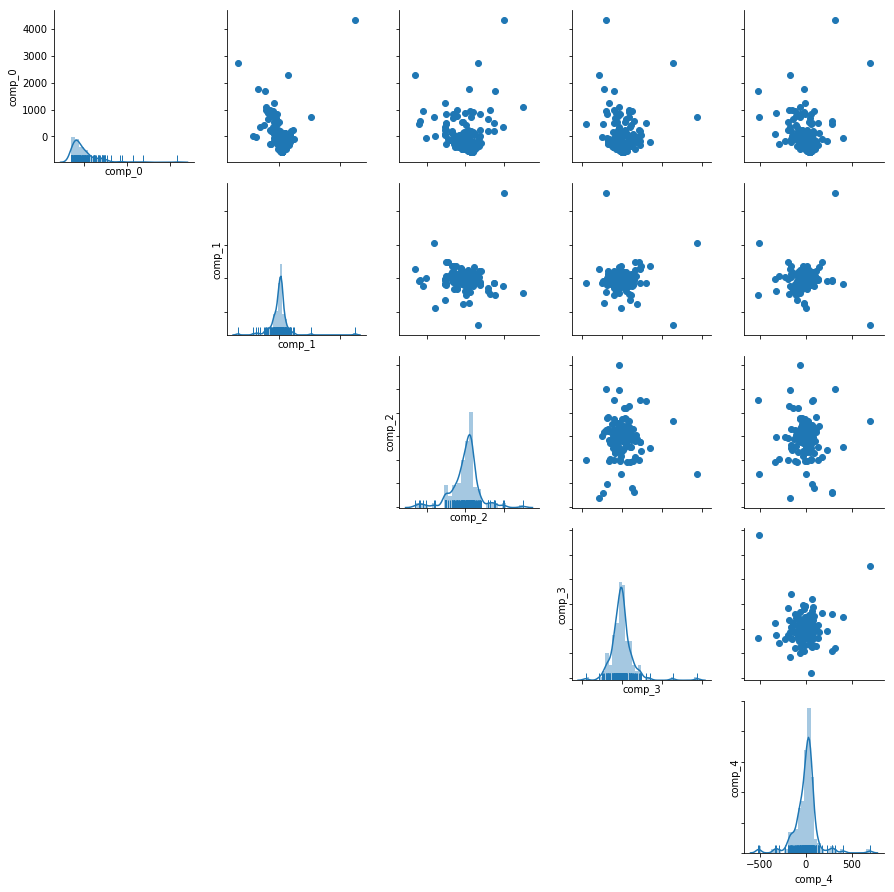

In [26]:
pca_cell_obs.plot_scores(n_components=5)

In [ ]:
# pca_cell_obs.plot_loading(0)
# plt.plot(pca_cell_obs.loadings_.iloc[:, 0])

Text(0, 0.5, 'loadings value')

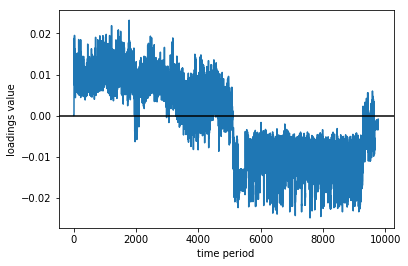

In [32]:
plt.plot(pca_cell_obs.loadings_.iloc[:, 1].values)
plt.axhline(0, c='black')
plt.xlabel('time period')
plt.ylabel('loadings value')

<b>sklearn PCA method</b>

In [24]:
####NOTE from PCA tutorial: normalize each cell to its average (so if 1 cell is 100Hz and another is 5Hz at baseline,
#we are just looking at deviations from their baselines)
epochrates_norm = epochrates.copy()
epochrates_norm -= epochrates.mean(axis=0)

In [26]:
pca = PCA(n_components=20)

In [27]:
pca.fit(epochrates_norm)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'Explained variance ratio')

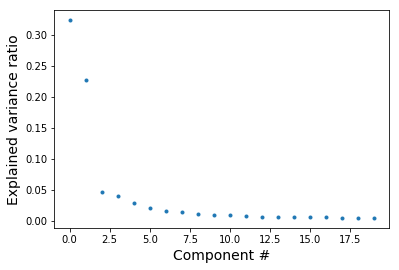

In [28]:
plt.figure()
plt.plot(pca.explained_variance_ratio_, '.')
plt.xlabel("Component #", fontsize=14)
plt.ylabel("Explained variance ratio", fontsize=14)

# plotname_fig2 = str(hcareas[0]) + '_ScreePlot_session' + str(seshid) +'.png'
# filename_fig2 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/'+ plotname_fig2)
# plt.savefig(filename_fig2,dpi=300)

In [29]:
response_reduced = pca.fit_transform(epochrates_norm)

Text(0, 0.5, 'Second principal component')

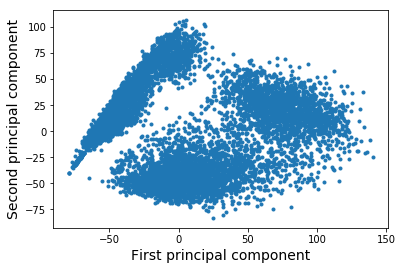

In [30]:
plt.figure()
plt.plot(response_reduced[:,0], response_reduced[:,1], '.')
plt.xlabel("First principal component", fontsize=14)
plt.ylabel("Second principal component", fontsize=14)

# plotname_fig3 = str(hcareas[0]) + '_PCAunlabeled_session' + str(seshid) +'.png'
# filename_fig3 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/'+ plotname_fig3)
# plt.savefig(filename_fig3,dpi=300)

Text(0, 0.5, 'Loading_PC1')

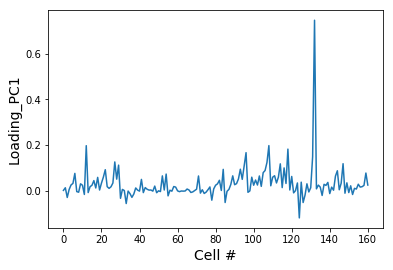

In [31]:
plt.figure()
plt.plot(pca.components_[0])
plt.xlabel("Cell #", fontsize=14)
plt.ylabel("Loading_PC1", fontsize=14)

# plotname_fig4 = str(hcareas[0]) + '_LoadingPC1_session' + str(seshid) +'.png'
# filename_fig4 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/'+ plotname_fig4)
# plt.savefig(filename_fig4,dpi=300)

Text(0, 0.5, 'Loading_PC2')

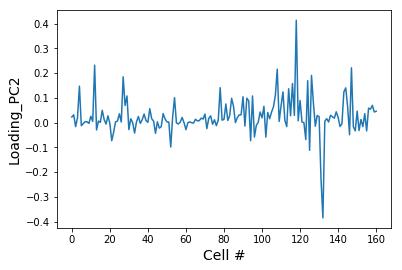

In [32]:
plt.figure()
plt.plot(pca.components_[1])
plt.xlabel("Cell #", fontsize=14)
plt.ylabel("Loading_PC2", fontsize=14)

# plotname_fig5 = str(hcareas[0]) + '_LoadingPC2_session' + str(seshid) +'.png'
# filename_fig5 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/'+ plotname_fig5)
# plt.savefig(filename_fig5,dpi=300)

In [33]:
#weird change in shape from epochrates to response_reduced, so I deal with it here
# by ensuring labels and response_reduced are same shape
response_reduced = response_reduced[0:labels.shape[0],:]

In [34]:
labels.shape[0], response_reduced.shape

(9774, (9774, 20))

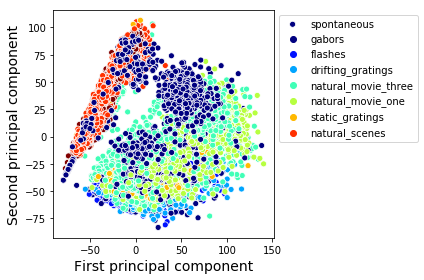

In [35]:
plt.figure()
sns.scatterplot(x=response_reduced[:,0],y=response_reduced[:,1],hue=labels,palette='jet',legend='full')
plt.xlabel("First principal component", fontsize=14)
plt.ylabel("Second principal component", fontsize=14)
plt.legend(epochuniques,bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

# plotname_fig6 = str(hcareas[0]) + '_PCA_withlabels_session' + str(seshid) +'.png'
# filename_fig6 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/'+ plotname_fig6)
# plt.savefig(filename_fig6,dpi=300)

In [36]:
label_natscene = np.where(epochuniques=='natural_scenes')[0][0]
label_driftgrat = np.where(epochuniques=='drifting_gratings')[0][0]
# label_natmov3 = np.where(epochuniques=='natural_movie_three')[0][0]


In [37]:
proj_natscene = response_reduced[labels==label_natscene]
proj_driftgrat = response_reduced[labels==label_driftgrat]

lab_natscene = labels[labels==label_natscene]
lab_driftgrat = labels[labels==label_driftgrat]

lab_NatDrift = np.append(lab_natscene,lab_driftgrat,axis=0)
proj_NatDrift = np.vstack((proj_natscene,proj_driftgrat))

epochuniq_NatDrift = epochuniques[np.unique(np.array(lab_NatDrift,dtype=int))]

In [38]:
lab_NatDrift.shape

(3377,)

In [39]:
proj_NatDrift.shape

(3377, 20)

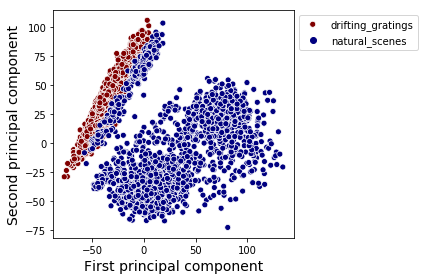

In [40]:
plt.figure()
sns.scatterplot(x=proj_NatDrift[:,0],y=proj_NatDrift[:,1],hue=lab_NatDrift,palette='jet',legend='full')
plt.xlabel("First principal component", fontsize=14)
plt.ylabel("Second principal component", fontsize=14)
plt.legend(epochuniq_NatDrift,bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

# plotname_fig6 = str(hcareas[0]) + '_PCA_withlabels_session' + str(seshid) +'.png'
# filename_fig6 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/'+ plotname_fig6)
# plt.savefig(filename_fig6,dpi=300)

In [31]:
############# 3D ADVENTURES IN EIGENSPACE #############
# %matplotlib notebook
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(response_reduced[:,0],response_reduced[:,1], response_reduced[:,2], c=labels,cmap='jet')
# ax.set_xlabel("First principal component", fontsize=14)
# ax.set_ylabel("Second principal component", fontsize=14)
# ax.set_zlabel("Third principal component", fontsize=14)
# # plt.legend(epochuniques,bbox_to_anchor=(1, 1), loc='upper left')
# plt.legend(epochuniques,loc='upper right')

<b>clustering steps</b>
1) do LDA, also SVM to decode back clusers (after split test train)
2) calculate mahalonabis distance between clusters
3) umap

<i>LDA, SVM</i>

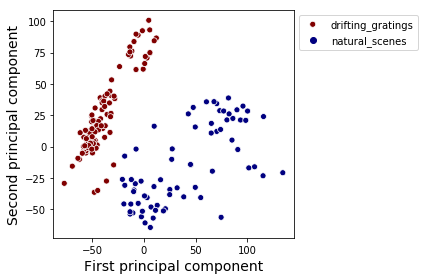

In [48]:
# [X_train,X_test,y_train,y_test] = model_selection.train_test_split(response_reduced[:,0:2],labels,test_size=0.05)
[X_train,X_test,y_train,y_test] = model_selection.train_test_split(proj_NatDrift[:,0:2],lab_NatDrift,test_size=0.05)

classifier = LDA()
classifier.fit(X_train,y_train)
y_hat = classifier.predict(X_test)

plt.figure()
sns.scatterplot(x=X_test[:,0],y=X_test[:,1],hue=y_hat,palette='jet',legend='full')
plt.xlabel("First principal component", fontsize=14)
plt.ylabel("Second principal component", fontsize=14)
plt.legend(epochuniq_NatDrift,bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

Text(0.5, 1.0, 'Session_744228101_Confusion')

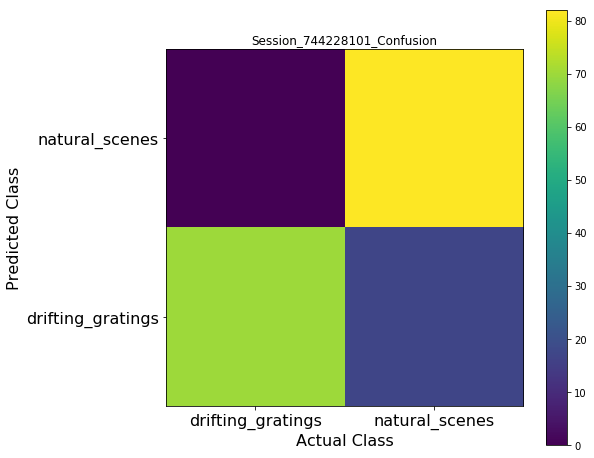

In [66]:
C = confusion_matrix(y_test,y_hat)

plt.figure(figsize=(8,8))
ax = plt.subplot(111)
cax = ax.imshow(C,interpolation='none',origin='lower',vmin=0,vmax=C.max())
ax.set_xlabel('Actual Class',fontsize=16)
ax.set_ylabel('Predicted Class',fontsize=16)
ax.set_xticks(range(2))
ax.set_xticklabels(epochuniq_NatDrift,fontsize=16)
ax.set_yticks(range(2))
ax.set_yticklabels(epochuniq_NatDrift,fontsize=16)
plt.colorbar(cax)
plt.title(str('Session_'+ str(seshid) + '_Confusion'))

In [24]:
decode_accuracy = pd.DataFrame(columns=['Session','Region','driftgrat_true','driftgrat_false',
                                        'natscene_false','natscene_true'])

df_sesh = {'Session':seshid,'Region':hcareas[0],'driftgrat_true':C[0,0],'driftgrat_false':C[0,1],
                                        'natscene_false':C[1,0],'natscene_true':C[1,1]}
decode_accuracy.append(df_sesh,ignore_index=True)

NameError: name 'C' is not defined

In [85]:
decode_accuracy.to_csv?

In [ ]:
# scores = model_selection.cross_validate(classifier,response_reduced[:,0:2],labels, cv=5, return_train_score=True)

# plt.figure(figsize=(8,8))
# ax = plt.subplot(111)
# ax.bar([0,1],[np.mean(scores['train_score']),np.mean(scores['test_score'])],color='c')
# ax.set_xticks([0.5,1.5])
# ax.set_xticklabels(['Train','Test'],fontsize=16)
# ax.set_ylabel('Fraction Correct',fontsize=16)
# plt.show()

<i>after running pca_lda_allsessions.py for CA and VISp</i>

In [17]:
#####look at discriminality across session in time.... MAKE SURE TO RETURN TO THIS

sessionnames = []
sessiontimes = []
for sesh in hc_sessions:
    sessionnames.append(sesh)
    sess = cache.get_session_data(sesh)
    sessiontimes.append(sess.session_start_time)

In [18]:
sessions_sorted = np.asarray(sessionnames)[np.argsort(sessiontimes)]

<i>Drifting gradients vs Natural scenes</i>

In [19]:
csv_CA = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/PCA_LDA/CA/CA_LDA_accuracy_.csv')
csv_VISp = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/PCA_LDA/VISp/VISp_LDA_accuracy_.csv')

accuracy_ca = pd.read_csv(csv_CA)
accuracy_v1 = pd.read_csv(csv_VISp)

In [20]:
#sort by Session occurrence in time

accuracy_ca['Session'] = pd.Categorical(accuracy_ca['Session'],sessions_sorted)
accuracy_ca = accuracy_ca.sort_values('Session')

accuracy_v1['Session'] = pd.Categorical(accuracy_v1['Session'],sessions_sorted)
accuracy_v1 = accuracy_v1.sort_values('Session')

In [21]:
import matplotlib.patches as mpatches

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


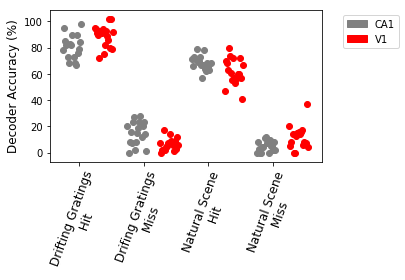

In [22]:
x_ca = [1,3,5,7]
y_ca = [accuracy_ca.driftgrat_true,accuracy_ca.driftgrat_false,accuracy_ca.natscene_true,accuracy_ca.natscene_false]

x_v1 = [2,4,6,8]
y_v1 = [accuracy_v1.driftgrat_true,accuracy_v1.driftgrat_false,accuracy_v1.natscene_true,accuracy_v1.natscene_false]

for xe, ye in zip(x_ca, y_ca):
#     randlist = np.random.rand(len(ye))/5
    randlist = np.arange(len(ye))/30
    plt.scatter([xe] * len(ye) + randlist, ye,color='grey')
for xe, ye in zip(x_v1, y_v1):
#     randlist = np.random.rand(len(ye))/5
    randlist = np.arange(len(ye))/30
    plt.scatter([xe] * len(ye) + randlist, ye,color='red')

plt.xticks([1.5,3.5,5.5,7.5],rotation=70)
plt.ylabel('Decoder Accuracy (%)',fontsize=12)
# plt.axes().set_xticklabels(df_accuracy.columns[[-4,-3,-1,-2]],fontsize=12)
plt.axes().set_xticklabels(['Drifting Gratings\n Hit','Drifing Gratings\n Miss',
                            'Natural Scene\n Hit', 'Natural Scene\n Miss'],fontsize=12)
capatch = mpatches.Patch(color='gray',label='CA1')
v1patch = mpatches.Patch(color='red',label='V1')
plt.legend(handles = [capatch,v1patch],bbox_to_anchor=(1.3, 1),loc='upper right',prop={'size': 10})
plt.tight_layout()

plotname_fig10 = 'decoder_accuracy_driftgratnatscene.png'
filename_fig10 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/PCA_LDA/'+ plotname_fig10)
plt.savefig(filename_fig10,dpi=300)

In [24]:
hit_drift = accuracy_v1.driftgrat_true
miss_drift = accuracy_v1.driftgrat_false
hit_nat = accuracy_v1.natscene_true
miss_nat = accuracy_v1.natscene_true
calcacc_v1 = np.divide(np.add(hit_drift,hit_nat),np.add(np.add(hit_drift,hit_nat),np.add(miss_drift,miss_nat)))

hit_drift = accuracy_v1.driftgrat_true
miss_drift = accuracy_v1.driftgrat_false
hit_nat = accuracy_v1.natscene_true
miss_nat = accuracy_v1.natscene_true
calcacc_ca = np.divide(np.add(hit_drift,hit_nat),np.add(np.add(hit_drift,hit_nat),np.add(miss_drift,miss_nat)))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


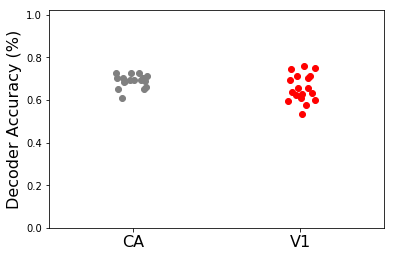

In [58]:
x_ca = 0.9
y_ca = calcacc_ca

x_v1 = 1.9
y_v1 = calcacc_v1

for ye in y_ca:
    randlist = np.random.rand()/5
    plt.scatter(x_ca + randlist, ye,color='grey')
for ye in y_v1:
    randlist = np.random.rand()/5
    plt.scatter(x_v1 + randlist, ye,color='red')

plt.xticks([1,2])
plt.ylabel('Decoder Accuracy (%)',fontsize=16)
plt.axes().set_xticklabels(['CA','V1'],fontsize=16)
# capatch = mpatches.Patch(color='gray',label='CA1')
# v1patch = mpatches.Patch(color='red',label='V1')
# plt.legend(handles = [capatch,v1patch],bbox_to_anchor=(1.3, 1),loc='upper right',prop={'size': 10})
# plt.tight_layout()
plt.xlim(0.5,2.5)
plt.ylim(0,1.02)

plotname_fig10 = 'decoder_accuracy_driftvsnat.png'
filename_fig10 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/PCA_LDA/'+ plotname_fig10)
plt.savefig(filename_fig10,dpi=300)

<i>Spontaneous vs Drifting gradients</i>

In [49]:
csv_CA = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/PCA_LDA/CA/CA_LDA_accuracy_spontdrift.csv')
csv_VISp = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/PCA_LDA/VISp/VISp_LDA_accuracy_spontdrift.csv')

accuracy_ca = pd.read_csv(csv_CA)
accuracy_v1 = pd.read_csv(csv_VISp)

In [50]:
#sort by Session occurrence in time

accuracy_ca['Session'] = pd.Categorical(accuracy_ca['Session'],sessions_sorted)
accuracy_ca = accuracy_ca.sort_values('Session')

accuracy_v1['Session'] = pd.Categorical(accuracy_v1['Session'],sessions_sorted)
accuracy_v1 = accuracy_v1.sort_values('Session')

In [51]:
import matplotlib.patches as mpatches

In [52]:
accuracy_ca.columns

Index(['Unnamed: 0', 'Session', 'Region', 'spont_true', 'spont_false',
       'driftgrat_false', 'driftgrat_true'],
      dtype='object')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


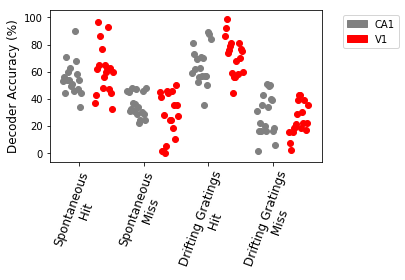

In [53]:
x_ca = [1,3,5,7]
y_ca = [accuracy_ca.spont_true,accuracy_ca.spont_false,accuracy_ca.driftgrat_true,accuracy_ca.driftgrat_false]

x_v1 = [2,4,6,8]
y_v1 = [accuracy_v1.spont_true,accuracy_v1.spont_false,accuracy_v1.driftgrat_true,accuracy_v1.driftgrat_false]

for xe, ye in zip(x_ca, y_ca):
#     randlist = np.random.rand(len(ye))/5
    randlist = np.arange(len(ye))/30
    plt.scatter([xe] * len(ye) + randlist, ye,color='grey')
for xe, ye in zip(x_v1, y_v1):
#     randlist = np.random.rand(len(ye))/5
    randlist = np.arange(len(ye))/30
    plt.scatter([xe] * len(ye) + randlist, ye,color='red')

plt.xticks([1.5,3.5,5.5,7.5],rotation=70)
plt.ylabel('Decoder Accuracy (%)',fontsize=12)
# plt.axes().set_xticklabels(df_accuracy.columns[[-4,-3,-1,-2]],fontsize=12)
plt.axes().set_xticklabels(['Spontaneous\n Hit','Spontaneous\n Miss',
                            'Drifting Gratings\n Hit', 'Drifting Gratings\n Miss'],fontsize=12)
capatch = mpatches.Patch(color='gray',label='CA1')
v1patch = mpatches.Patch(color='red',label='V1')
plt.legend(handles = [capatch,v1patch],bbox_to_anchor=(1.3, 1),loc='upper right',prop={'size': 10})
plt.tight_layout()

plotname_fig11 = 'decoder_accuracy_spontdriftgrat.png'
filename_fig11 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/PCA_LDA/'+ plotname_fig11)
plt.savefig(filename_fig11,dpi=300)

In [54]:
hit_spont = accuracy_v1.spont_true
miss_spont = accuracy_v1.spont_false
hit_drift = accuracy_v1.driftgrat_true
miss_drift = accuracy_v1.driftgrat_false
calcacc_v1 = np.divide(np.add(hit_spont,hit_drift),np.add(np.add(hit_spont,hit_drift),np.add(miss_spont,miss_drift)))

hit_spont = accuracy_ca.spont_true
miss_spont = accuracy_ca.spont_false
hit_drift = accuracy_ca.driftgrat_true
miss_drift = accuracy_ca.driftgrat_false
calcacc_v1 = np.divide(np.add(hit_spont,hit_drift),np.add(np.add(hit_spont,hit_drift),np.add(miss_spont,miss_drift)))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


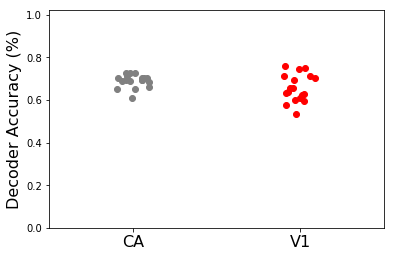

In [59]:
x_ca = 0.9
y_ca = calcacc_ca

x_v1 = 1.9
y_v1 = calcacc_v1

for ye in y_ca:
    randlist = np.random.rand()/5
    plt.scatter(x_ca + randlist, ye,color='grey')
for ye in y_v1:
    randlist = np.random.rand()/5
    plt.scatter(x_v1 + randlist, ye,color='red')

plt.xticks([1,2])
plt.ylabel('Decoder Accuracy (%)',fontsize=16)
plt.axes().set_xticklabels(['CA','V1'],fontsize=16)
# capatch = mpatches.Patch(color='gray',label='CA1')
# v1patch = mpatches.Patch(color='red',label='V1')
# plt.legend(handles = [capatch,v1patch],bbox_to_anchor=(1.3, 1),loc='upper right',prop={'size': 10})
# plt.tight_layout()
plt.xlim(0.5,2.5)
plt.ylim(0,1.02)

plotname_fig10 = 'decoder_accuracy_spontvsdrift.png'
filename_fig10 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/PCA_LDA/'+ plotname_fig10)
plt.savefig(filename_fig10,dpi=300)

<i> mahalonabis dist </i>

In [67]:
np.unique(labels,return_counts=True)[1]

array([1764,  912,  298, 1889, 1201,  600, 1501, 1489])

In [72]:
splitarray = np.split(response_reduced[:,0],np.unique(labels,return_counts=True)[1])

TypeError: only integer scalar arrays can be converted to a scalar index

In [56]:
from sklearn.metrics import pairwise_distances

mah_dist = pairwise_distances(response_reduced,metric='mahalanobis')

In [57]:
mah_dist.shape

(9654, 9654)

<i>umap</i>

<b>Naive Bayes</b>

In [159]:
[X_train,X_test,y_train,y_test] = model_selection.train_test_split(epochrates,epochlabels[0],test_size=0.2)

clf = GaussianNB()
clf.fit(X_train, y_train)
GaussianNB(priors=None, var_smoothing=1e-09)
y_hat = clf.predict(X_test)
y_hat
# plot_test_performance(X,Y,y_hat)

array([0, 0, 0, 0, 0, 0])

In [32]:
# def plot_test_performance(data,class_labels,prediction):
    
#     classes = np.unique(class_labels)
#     num_classes = len(classes)
    
#     color = 'rbgmyk'
    
#     plt.figure(figsize=(8,8))
#     for cl in range(num_classes):
        
#         is_class = y == cl
#         is_correct = y == prediction
        
#         plt.scatter(data[is_class & is_correct,0],
#                     data[is_class & is_correct,1],
#                     c=color[cl],edgecolor='none')
#         plt.scatter(data[is_class & ~is_correct,0],
#                     data[is_class & ~is_correct,1],
#                     c='none',edgecolor=color[cl])
        
#     plt.xlim(data[:,0].min(),data[:,0].max())
#     plt.ylim(data[:,1].min(),data[:,1].max())
#     plt.show()

In [18]:
# clf_pf = GaussianNB()
# clf_pf.partial_fit(X, Y, np.unique(Y))
# GaussianNB(priors=None, var_smoothing=1e-09)
# print(clf_pf.predict([[-0.8, -1]]))

[1]


In [49]:
#EXAMPLE

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
Y = np.array([1, 1, 1, 2, 2, 2])
X_test = np.array([[-4, -5], [-3, -1], [3, -2], [4, -1], [-2, 1], [3, 3]])

clf = GaussianNB()
clf.fit(X, Y)
GaussianNB(priors=None, var_smoothing=1e-09)
y_hat = clf.predict(X_test)
y_hat
# plot_test_performance(X,Y,y_hat)

array([1, 1, 1, 2, 1, 2])

In [ ]:
######### TO DO ##############
#confusion matrix to test accuracy